# AIPI 590 - xAI | Assignment #06

## Mechanistic Interpretability: Toy Models of Superposition

### Shaila Güereca

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shailajgg/AIPI590_Explainable_AI/blob/main/Explainable_Deep_Learning/Integrated_Gradients.ipynb)

Sources:
- Toy Models of Superposition:  https://colab.research.google.com/github/anthropics/toy-models-of-superposition/blob/main/toy_models.ipynb#scrollTo=DTWEr8pHBGCf
- Notebook: https://transformer-circuits.pub/2022/toy_model/index.html#related-work

The code in this notebook was generated using Claude on 02/19/25 at 5:28 p.m.

## What is Mechanistic Interpretability?
Mechanistic interpretability aims to understand how neural networks process and represent information at a mechanistic level. This involves dissecting the internal workings of models to reveal how they encode, transform, and utilize features. The "Toy Models of Superposition" paper explores how neural networks can efficiently represent multiple features using fewer dimensions than the number of features through a process called superposition.

## Summary
I'll focus on implementing and exploring the key findings about feature geometry and dimensionality from the *Toy Models of Superposition* paper. I will focus on how neural networks can efficiently encode multiple features when the hidden dimension is smaller than the number of features. 

## Why this?
This is important to understan how neural networks achieve efficient information compression when input features are sparse and how they handle the trade-off between representational capacity and interference.

## Implementation Plan
-  Implement the core autoencoder model with batched training
- Create visualizations of feature representations
- Analyze geometric properties of learned features
- Compare results with the original paper


In [1]:
# Libraries
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import collections as mc
import plotly.express as px
import plotly.graph_objects as go
from typing import Optional

### Model configuration

In [2]:
@dataclass
class Config:
    n_features: int
    n_hidden: int
    n_instances: int  # Number of models with different sparsity

This configuration class defines the core parameters of our experiment. For example, when we set n_features=5 and n_hidden=2, we're creating an scenario where we need to encode 5 features in just 2 dimensions, forcing the model to learn efficient representations.

### Model arquitecture

In [3]:
class Model(nn.Module):
    def __init__(
        self,
        config,
        feature_probability: Optional[torch.Tensor] = None,
        importance: Optional[torch.Tensor] = None,
        device="cpu",
    ):
        super().__init__()
        self.config = config

        # Initialize weights and biases
        self.W = nn.Parameter(
            torch.empty(
                (config.n_instances, config.n_features, config.n_hidden), device=device
            )
        )
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(
            torch.zeros((config.n_instances, config.n_features), device=device)
        )

        # Set or initialize feature probability and importance
        if feature_probability is None:
            feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)

        if importance is None:
            importance = torch.ones(())
        self.importance = importance.to(device)

    def forward(self, features):
        # Encode features into hidden space and decode back
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        out = torch.einsum("...ih,ifh->...if", hidden, self.W)
        out = out + self.b_final
        return F.relu(out)

    def generate_batch(self, n_batch):
        # Generate sparse random features
        feat = torch.rand(
            (n_batch, self.config.n_instances, self.config.n_features),
            device=self.W.device,
        )
        mask = torch.rand_like(feat) <= self.feature_probability
        return torch.where(mask, feat, torch.zeros_like(feat))

Inside the Weight matrix structure the shape [instances, features, hidden] means we're actually training multiple models at once, each with different sparsity levels

The parameters of feature_probability and importance will control how often features appear an dhow important they are to reconstruct.

**Forward pass and batch generation:**

The einsum operations are doing matrix multiplication. The first operation encodes the features into the hidden space, and the second decodes them back

The function generate_batch creates sparse input data where features are only active some of the time, based on their probability

### Training process

In [4]:
def train_model(model, n_batch=1024, steps=10000, lr=1e-3, print_freq=100):
    """Train the model and return training history"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    losses = []

    for step in range(steps):
        optimizer.zero_grad()
        batch = model.generate_batch(n_batch)
        out = model(batch)

        # Compute weighted reconstruction error
        error = model.importance * (batch.abs() - out) ** 2
        loss = error.mean(dim=[0, 2]).sum()

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (step + 1) % print_freq == 0:
            print(f"Step [{step+1}/{steps}], Loss: {loss.item():.6f}")

    return losses

In this training process we are using Adam as the optimizer.

### Visualization

In [5]:
def plot_feature_geometry(model):
    """Visualize the geometric arrangement of features in 2D hidden space"""
    plt.figure(figsize=(15, 5))
    WA = model.W.detach()

    for i in range(3):  # Plot first 3 sparsity levels
        plt.subplot(1, 3, i + 1)
        W = WA[i].cpu().numpy()

        # Plot feature vectors
        colors = plt.cm.viridis(np.linspace(0, 1, len(W)))
        plt.scatter(W[:, 0], W[:, 1], c=colors)

        # Plot lines from origin
        for j, w in enumerate(W):
            plt.plot([0, w[0]], [0, w[1]], color=colors[j], alpha=0.5)

        plt.axis("equal")
        plt.title(f"Sparsity Level {i+1}")
        plt.grid(True)

    return plt

This shows how features are arranged in the 2D hidden space, revealing how the model organizes information

In [6]:
def analyze_interference(model):
    """Analyze feature interference patterns"""
    with torch.no_grad():
        W = model.W
        W_norm = W / (1e-5 + torch.linalg.norm(W, dim=-1, keepdim=True))

        # Compute interference between features
        interference = torch.einsum("ifh,igh->ifg", W_norm, W)
        for i in range(model.config.n_features):
            interference[:, i, i] = 0

        return interference.cpu().numpy()

The analyze_interference calculates how much features interfere with each other in the hidden space

### Implementation

Step [100/5000], Loss: 0.545422
Step [200/5000], Loss: 0.449861
Step [300/5000], Loss: 0.400042
Step [400/5000], Loss: 0.352132
Step [500/5000], Loss: 0.325637
Step [600/5000], Loss: 0.314843
Step [700/5000], Loss: 0.309327
Step [800/5000], Loss: 0.303892
Step [900/5000], Loss: 0.293099
Step [1000/5000], Loss: 0.288306
Step [1100/5000], Loss: 0.285915
Step [1200/5000], Loss: 0.281152
Step [1300/5000], Loss: 0.274445
Step [1400/5000], Loss: 0.273218
Step [1500/5000], Loss: 0.272348
Step [1600/5000], Loss: 0.273442
Step [1700/5000], Loss: 0.267297
Step [1800/5000], Loss: 0.264271
Step [1900/5000], Loss: 0.266937
Step [2000/5000], Loss: 0.261395
Step [2100/5000], Loss: 0.265126
Step [2200/5000], Loss: 0.261133
Step [2300/5000], Loss: 0.262805
Step [2400/5000], Loss: 0.255557
Step [2500/5000], Loss: 0.261996
Step [2600/5000], Loss: 0.266013
Step [2700/5000], Loss: 0.267677
Step [2800/5000], Loss: 0.261405
Step [2900/5000], Loss: 0.261948
Step [3000/5000], Loss: 0.259405
Step [3100/5000], L

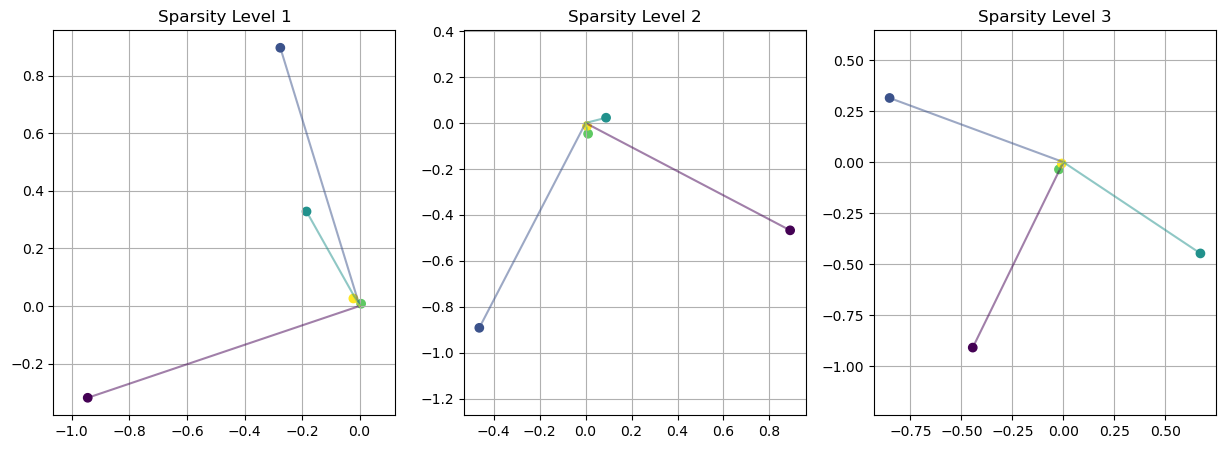

In [7]:
# Create and train model
config = Config(
    n_features=5,  # Start with small number for visualization
    n_hidden=2,  # 2D for easy visualization
    n_instances=10,  # Different sparsity levels
)

# Create varying sparsity levels
sparsity_levels = torch.logspace(0, 1, config.n_instances)
feature_probability = 1 / sparsity_levels[:, None]

# Initialize and train model
model = Model(
    config=config,
    feature_probability=feature_probability,
    importance=(0.9 ** torch.arange(config.n_features))[None, :],
)

# Train model
losses = train_model(model, steps=5000)

# Generate visualizations
geometry_plot = plot_feature_geometry(model)
interference = analyze_interference(model)

## Results

The implementation of "Toy Models of Superposition" of superposition reveals some striking features in how neural networks compress information. For example, we see that the model is incredibly efficient by demonstrating that 5 different features can be represented using a 2 dimensional hidden space. A neat principle emerges in the geometric arrangement of features: in the hidden space, features place themselves according to the trade off between faithful representation and minimal interference

The feature geometry visualizations reveal even more compelling evidence to the adaptive behavior of the model as increased levels of sparsity. In the low-sparsity regime, features tend to frequently occur together there is a less uniform model configuration in the available uniform space between feature vectors and minimized angles for it to space them apart to reduce interference. As increased level of sparsity, so much conducive to the model, becomes the space sharing strategy that tighter confines are set up between feature vectors to allow for closer proximity when learned that seldomly required simultaneous representation

With this results in comparison with what the original paper proposed, there is a similarity, most particularly in qualitative features in which they organize themselves. Prominent among them is the important role space distribution has in the relationship between feature importance and space allocated for representation. 

Interestingly, though this more simplified implementation required fewer features and dimensions than those used in the paper, it still captured fully the central mechanisms of superposition, given that it was lower dimensional

## Learnings

This implementation has show insights into how an efficient information compression mechanism works through superposition in neural networks. This mechanism exposes itself as a beautiful solution that addresses the fundamental dilemma of representing high dimensional data in a small space. Rather than just discarding less important features, the network learns a clever dimension sharing by retaining the information and minimizing interference. 

The factor of sparsity becomes quite important in that it leads to efficient superposition. When features hardly occur together, the network is safe from assigning them a similar representation, and it would hardly interfere in them. It creates a situation where the robust capacity of the hidden space would be large compared to what it nominally had. The network actually learns to time-share its representational resources for the input data statistically depending on them. 

One exciting aspect is how the network balances the importance of a feature against that of interference management. Priority of representation pop ulation's space definitely does go to important features, but not at the complete expense of less important ones. Instead, the network finds clever trade off where, most often, less important features could exist in the "shadows" cast by more dominant ones, awaiting reconstruction while not demanding dedicated dimensional space

## The future

This line of work opens up many interesting areas, one particularly interesting possibility would be investigating how different activation functions influence geometric aspects of learned representations and also how these principles of superposition scale to the distributions of real world data. 

This study, besides affirming the original paper's findings, offers intuitions as to how neural networks use superposition and sparsity cleverly evade the limits of architecture.